##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFRecord and tf.train.Example

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/tfrecord"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/tfrecord.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/tfrecord.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/tfrecord.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

The TFRecord format is a simple format for storing a sequence of binary records.

[Protocol buffers](https://developers.google.com/protocol-buffers/) are a cross-platform, cross-language library for efficient serialization of structured data.

Protocol messages are defined by `.proto` files, these are often the easiest way to understand a message type.

The `tf.train.Example` message (or protobuf) is a flexible message type that represents a `{"string": value}` mapping. It is designed for use with TensorFlow and is used throughout the higher-level APIs such as [TFX](https://www.tensorflow.org/tfx/).

In [ ]:
### > TFX == TensorFlow for Production - "An extended TF for end-to-end pipelines"

### tf.train.Example  seems to be a type of protocal buffer, i.e. file cross-prog.language file format

This notebook will demonstrate how to create, parse, and use the `tf.train.Example` message, and then serialize, write, and read `tf.train.Example` messages to and from `.tfrecord` files.

Note: While useful, these structures are optional. There is no need to convert existing code to use TFRecords, unless you are using [`tf.data`](https://www.tensorflow.org/guide/datasets) and reading data is still the bottleneck to training. See [Data Input Pipeline Performance](https://www.tensorflow.org/guide/performance/datasets) for dataset performance tips.

Note: In general, you should shard your data across multiple files so that you can parallelize I/O (within a single host or across multiple hosts). The rule of thumb is to have at least 10 times as many files as there will be hosts reading data. At the same time, each file should be large enough (at least 10+MB and ideally 100MB+) so that you benefit from I/O prefetching. For example, say you have `X` GBs of data and you plan to train on up to `N` hosts. Ideally, you should shard the data to ~`10*N` files, as long as ~`X/(10*N)` is 10+ MBs (and ideally 100+ MBs). If it is less than that, you might need to create fewer shards to trade off parallelism benefits and I/O prefetching benefits.

In [ ]:
### > 10 * N files & X / (10 * N) > 10 MB (ideally 100 MB)

## Setup

In [3]:
import tensorflow as tf

import numpy as np
import IPython.display as display

## `tf.train.Example`

### Data types for `tf.train.Example`

Fundamentally, a `tf.train.Example` is a `{"string": tf.train.Feature}` mapping.

The `tf.train.Feature` message type can accept one of the following three types (See the [`.proto` file](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto) for reference). Most other generic types can be coerced into one of these:

1. `tf.train.BytesList` (the following types can be coerced)

  - `string`
  - `byte`

1. `tf.train.FloatList` (the following types can be coerced)

  - `float` (`float32`)
  - `double` (`float64`)

1. `tf.train.Int64List` (the following types can be coerced)

  - `bool`
  - `enum`
  - `int32`
  - `uint32`
  - `int64`
  - `uint64`

In order to convert a standard TensorFlow type to a `tf.train.Example`-compatible `tf.train.Feature`, you can use the shortcut functions below. Note that each function takes a scalar input value and returns a `tf.train.Feature` containing one of the three `list` types above:

In [4]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

Note: To stay simple, this example only uses scalar inputs. The simplest way to handle non-scalar features is to use `tf.io.serialize_tensor` to convert tensors to binary-strings. Strings are scalars in tensorflow. Use `tf.io.parse_tensor` to convert the binary-string back to a tensor.

Below are some examples of how these functions work. Note the varying input types and the standardized output types. If the input type for a function does not match one of the coercible types stated above, the function will raise an exception (e.g. `_int64_feature(1.0)` will error out, since `1.0` is a float, so should be used with the `_float_feature` function instead):

In [5]:
print(_bytes_feature(b'test_string')) # > b means byte
print(_bytes_feature(u'test_bytes'.encode('utf-8'))) # > u means unicode

print(_float_feature(np.exp(1)))

print(_int64_feature(True))
print(_int64_feature(1))

bytes_list {
  value: "test_string"
}

bytes_list {
  value: "test_bytes"
}

float_list {
  value: 2.7182817459106445
}

int64_list {
  value: 1
}

int64_list {
  value: 1
}



All proto messages can be serialized to a binary-string using the `.SerializeToString` method:

In [6]:
feature = _float_feature(np.exp(1))

feature.SerializeToString()

b'\x12\x06\n\x04T\xf8-@'

### Creating a `tf.train.Example` message

Suppose you want to create a `tf.train.Example` message from existing data. In practice, the dataset may come from anywhere, but the procedure of creating the `tf.train.Example` message from a single observation will be the same:

1. Within each observation, each value needs to be converted to a `tf.train.Feature` containing one of the 3 compatible types, using one of the functions above.

1. You create a map (dictionary) from the feature name string to the encoded feature value produced in #1.

1. The map produced in step 2 is converted to a [`Features` message](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/feature.proto#L85).

In this notebook, you will create a dataset using NumPy.

This dataset will have 4 features:

* a boolean feature, `False` or `True` with equal probability
* an integer feature uniformly randomly chosen from `[0, 5]`
* a string feature generated from a string table by using the integer feature as an index
* a float feature from a standard normal distribution

Consider a sample consisting of 10,000 independently and identically distributed observations from each of the above distributions:

In [7]:
# The number of observations in the dataset.
n_observations = int(1e4)

# Boolean feature, encoded as False or True.
feature0 = np.random.choice([False, True], n_observations)

# Integer feature, random from 0 to 4.
feature1 = np.random.randint(0, 5, n_observations)

# String feature
strings = np.array([b'cat', b'dog', b'chicken', b'horse', b'goat'])
feature2 = strings[feature1]

# Float feature, from a standard normal distribution
feature3 = np.random.randn(n_observations)

In [11]:
x = np.random.randint(0, 1, 1000)
y = np.array([1])
z = y[x]
z.shape # > Broadcasts it to be 1000 1's

(1000,)

In [12]:
feature2.shape

(10000,)

Each of these features can be coerced into a `tf.train.Example`-compatible type using one of `_bytes_feature`, `_float_feature`, `_int64_feature`. You can then create a `tf.train.Example` message from these encoded features:

In [13]:
def serialize_example(feature0, feature1, feature2, feature3):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'feature0': _int64_feature(feature0),
      'feature1': _int64_feature(feature1),
      'feature2': _bytes_feature(feature2),
      'feature3': _float_feature(feature3),
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

For example, suppose you have a single observation from the dataset, `[False, 4, bytes('goat'), 0.9876]`. You can create and print the `tf.train.Example` message for this observation using `create_message()`. Each single observation will be written as a `Features` message as per the above. Note that the `tf.train.Example` [message](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/example/example.proto#L88) is just a wrapper around the `Features` message:

In [14]:
# This is an example observation from the dataset.

example_observation = []

serialized_example = serialize_example(False, 4, b'goat', 0.9876)
serialized_example

b'\nR\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04[\xd3|?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00'

To decode the message use the `tf.train.Example.FromString` method.

In [15]:
example_proto = tf.train.Example.FromString(serialized_example)
example_proto

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 4
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "goat"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: 0.9876000285148621
      }
    }
  }
}

## TFRecords format details

A TFRecord file contains a sequence of records. The file can only be read sequentially.

Each record contains a byte-string, for the data-payload, plus the data-length, and  CRC32C (32-bit CRC using the Castagnoli polynomial) hashes for integrity checking.

Each record is stored in the following formats:

    uint64 length
    uint32 masked_crc32_of_length
    byte   data[length]
    uint32 masked_crc32_of_data

The records are concatenated together to produce the file. CRCs are
[described here](https://en.wikipedia.org/wiki/Cyclic_redundancy_check), and
the mask of a CRC is:

    masked_crc = ((crc >> 15) | (crc << 17)) + 0xa282ead8ul


Note: There is no requirement to use `tf.train.Example` in TFRecord files. `tf.train.Example` is just a method of serializing dictionaries to byte-strings. Any byte-string that can be decoded in TensorFlow could be stored in a TFRecord file. Examples include: Lines of text, JSON (using `tf.io.decode_json_example`), encoded image data, or serialized `tf.Tensors` (using `tf.io.serialize_tensor`/`tf.io.parse_tensor`). See the `tf.io` module for more options.

## TFRecord files using `tf.data`

The `tf.data` module also provides tools for reading and writing data in TensorFlow.

### Writing a TFRecord file

The easiest way to get the data into a dataset is to use the `from_tensor_slices` method.

Applied to an array, it returns a dataset of scalars:

In [16]:
tf.data.Dataset.from_tensor_slices(feature1)

<TensorSliceDataset shapes: (), types: tf.int64>

Applied to a tuple of arrays, it returns a dataset of tuples:

In [17]:
features_dataset = tf.data.Dataset.from_tensor_slices((feature0, feature1, feature2, feature3))
features_dataset

<TensorSliceDataset shapes: ((), (), (), ()), types: (tf.bool, tf.int64, tf.string, tf.float64)>

In [18]:
# Use `take(1)` to only pull one example from the dataset.
for f0,f1,f2,f3 in features_dataset.take(1):
  print(f0)
  print(f1)
  print(f2)
  print(f3)

tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'dog', shape=(), dtype=string)
tf.Tensor(-0.6850024425420643, shape=(), dtype=float64)


Use the `tf.data.Dataset.map` method to apply a function to each element of a `Dataset`.

The mapped function must operate in TensorFlow graph mode—it must operate on and return `tf.Tensors`. A non-tensor function, like `serialize_example`, can be wrapped with `tf.py_function` to make it compatible.

Using `tf.py_function` requires to specify the shape and type information that is otherwise unavailable:

In [20]:
def tf_serialize_example(f0,f1,f2,f3):
  tf_string = tf.py_function(
    serialize_example,
    (f0,f1,f2,f3),  # pass these args to the above function.
    tf.string)      # the return type is `tf.string`.
  return tf.reshape(tf_string, ()) # The result is a scalar

In [21]:
tf_serialize_example(f0,f1,f2,f3)

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04R\\/\xbf'>

Apply this function to each element in the dataset:

In [22]:
serialized_features_dataset = features_dataset.map(tf_serialize_example)
serialized_features_dataset

<MapDataset shapes: (), types: tf.string>

In [23]:
def generator():
  for features in features_dataset:
    yield serialize_example(*features)

In [24]:
serialized_features_dataset = tf.data.Dataset.from_generator(
    generator, output_types=tf.string, output_shapes=())

In [25]:
serialized_features_dataset

<FlatMapDataset shapes: (), types: tf.string>

And write them to a TFRecord file:

In [27]:
filename = 'test.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

### Reading a TFRecord file

You can also read the TFRecord file using the `tf.data.TFRecordDataset` class.

More information on consuming TFRecord files using `tf.data` can be found [here](https://www.tensorflow.org/guide/datasets#consuming_tfrecord_data).

Using `TFRecordDataset`s can be useful for standardizing input data and optimizing performance.

In [28]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

At this point the dataset contains serialized `tf.train.Example` messages. When iterated over it returns these as scalar string tensors.

Use the `.take` method to only show the first 10 records.

Note: iterating over a `tf.data.Dataset` only works with eager execution enabled.

In [29]:
for raw_record in raw_dataset.take(10):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x01\n\x13\n\x08feature2\x12\x07\n\x05\n\x03dog\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04R\\/\xbf\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nR\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x04\n\x14\n\x08feature2\x12\x08\n\x06\n\x04goat\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04sk\xbb?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xb8=\x82?\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nU\n\x11\n\x08feature0\x12\x05\x1a\x03\n\x01\x00\n\x11\n\x08feature1\x12\x05\x1a\x03\n\x01\x02\n\x17\n\x08feature2\x12\x0b\n\t\n\x07chicken\n\x14\n\x08feature3\x12\x08\x12\x06\n\x04\xbby\xac>'>
<tf.Tensor: shape=(), dtype=string, numpy=b'\nQ\n\x1

These tensors can be parsed using the function below. Note that the `feature_description` is necessary here because datasets use graph-execution, and need this description to build their shape and type signature:

In [30]:
# Create a description of the features.
feature_description = {
    'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)

Alternatively, use `tf.parse example` to parse the whole batch at once. Apply this function to each item in the dataset using the `tf.data.Dataset.map` method:

In [31]:
parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset

<MapDataset shapes: {feature0: (), feature1: (), feature2: (), feature3: ()}, types: {feature0: tf.int64, feature1: tf.int64, feature2: tf.string, feature3: tf.float32}>

Use eager execution to display the observations in the dataset. There are 10,000 observations in this dataset, but you will only display the first 10. The data is displayed as a dictionary of features. Each item is a `tf.Tensor`, and the `numpy` element of this tensor displays the value of the feature:

In [32]:
for parsed_record in parsed_dataset.take(10):
  print(repr(parsed_record))

{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=-0.68500245>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'goat'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=1.4642166>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=1.0175085>}
{'feature0': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'feature1': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'feature2': <tf.Tensor: shape=(), dtype=string, numpy=b'chicken'>, 'feature3': <tf.Tensor: shape=(), dtype=float32, numpy=0.33686623>}
{'featur

Here, the `tf.parse_example` function unpacks the `tf.train.Example` fields into standard tensors.

## TFRecord files in Python

The `tf.io` module also contains pure-Python functions for reading and writing TFRecord files.

### Writing a TFRecord file

Next, write the 10,000 observations to the file `test.tfrecord`. Each observation is converted to a `tf.train.Example` message, then written to file. You can then verify that the file `test.tfrecord` has been created:

In [33]:
# Write the `tf.train.Example` observations to the file.
with tf.io.TFRecordWriter(filename) as writer:
  for i in range(n_observations):
    example = serialize_example(feature0[i], feature1[i], feature2[i], feature3[i])
    writer.write(example)

In [34]:
!du -sh {filename}

984K	test.tfrecord


### Reading a TFRecord file

These serialized tensors can be easily parsed using `tf.train.Example.ParseFromString`:

In [35]:
filenames = [filename]
raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [36]:
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "feature0"
    value {
      int64_list {
        value: 0
      }
    }
  }
  feature {
    key: "feature1"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "feature2"
    value {
      bytes_list {
        value: "dog"
      }
    }
  }
  feature {
    key: "feature3"
    value {
      float_list {
        value: -0.6850024461746216
      }
    }
  }
}



## Walkthrough: Reading and writing image data

This is an end-to-end example of how to read and write image data using TFRecords. Using an image as input data, you will write the data as a TFRecord file, then read the file back and display the image.

This can be useful if, for example, you want to use several models on the same input dataset. Instead of storing the image data raw, it can be preprocessed into the TFRecords format, and that can be used in all further processing and modelling.

First, let's download [this image](https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg) of a cat in the snow and [this photo](https://upload.wikimedia.org/wikipedia/commons/f/fe/New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg) of the Williamsburg Bridge, NYC under construction.

### Fetch the images

In [37]:
cat_in_snow  = tf.keras.utils.get_file('320px-Felis_catus-cat_on_snow.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')
williamsburg_bridge = tf.keras.utils.get_file('194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg')

16384/15477 [===============================] - 0s 0us/step


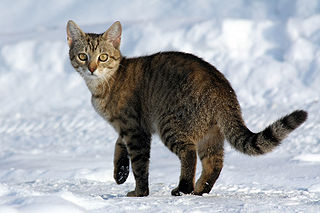

In [38]:
display.display(display.Image(filename=cat_in_snow))
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

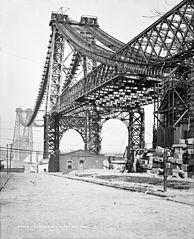

In [39]:
display.display(display.Image(filename=williamsburg_bridge))
display.display(display.HTML('<a "href=https://commons.wikimedia.org/wiki/File:New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg">From Wikimedia</a>'))

### Write the TFRecord file

As before, encode the features as types compatible with `tf.train.Example`. This stores the raw image string feature, as well as the height, width, depth, and arbitrary `label` feature. The latter is used when you write the file to distinguish between the cat image and the bridge image. Use `0` for the cat image, and `1` for the bridge image:

In [41]:
image_labels = {
    cat_in_snow : 0,
    williamsburg_bridge : 1,
}

In [53]:
# This is an example, just using the cat image.
image_string = open(cat_in_snow, 'rb').read() # > rb == read-only in binary

label = image_labels[cat_in_snow]

# Create a dictionary with features that may be relevant.
def image_example(image_string, label):
  image_shape = tf.image.decode_jpeg(image_string).shape

  feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
  }

  return tf.train.Example(features=tf.train.Features(feature=feature))

for line in str(image_example(image_string, label)).split('\n')[:15]:
  print(line)
print('...')

features {
  feature {
    key: "depth"
    value {
      int64_list {
        value: 3
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 213
      }
...


In [45]:
image_string

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x00\xd5\x01@\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x01\x06\x07\x08\x00\xff\xc4\x00?\x10\x00\x02\x01\x03\x03\x02\x05\x01\x05\x06\x05\x02\x06\x03\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13"Qaq\x07\x142\x81\x91\x08#B\xa1\xb1\xf0\x15R\xc1\xd1\xf1b\xe1\x16$3Cr\x824S\xb2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00\'\x11\x00\x02\x02\x02\x02\x02\x02\x03\x01\x01\x00\x03\x00\x00\x00\x00\x00\x01\x02\x11!1\x03\x12AQ\x04

In [46]:
str(image_example(image_string, label))

'features {\n  feature {\n    key: "depth"\n    value {\n      int64_list {\n        value: 3\n      }\n    }\n  }\n  feature {\n    key: "height"\n    value {\n      int64_list {\n        value: 213\n      }\n    }\n  }\n  feature {\n    key: "image_raw"\n    value {\n      bytes_list {\n        value: "\\377\\330\\377\\340\\000\\020JFIF\\000\\001\\001\\001\\000H\\000H\\000\\000\\377\\333\\000C\\000\\006\\004\\005\\006\\005\\004\\006\\006\\005\\006\\007\\007\\006\\010\\n\\020\\n\\n\\t\\t\\n\\024\\016\\017\\014\\020\\027\\024\\030\\030\\027\\024\\026\\026\\032\\035%\\037\\032\\033#\\034\\026\\026 , #&\\\')*)\\031\\037-0-(0%()(\\377\\333\\000C\\001\\007\\007\\007\\n\\010\\n\\023\\n\\n\\023(\\032\\026\\032((((((((((((((((((((((((((((((((((((((((((((((((((\\377\\300\\000\\021\\010\\000\\325\\001@\\003\\001\\021\\000\\002\\021\\001\\003\\021\\001\\377\\304\\000\\034\\000\\000\\002\\002\\003\\001\\001\\000\\000\\000\\000\\000\\000\\000\\000\\000\\000\\003\\004\\002\\005\\001\\006\\007\\010\

Notice that all of the features are now stored in the `tf.train.Example` message. Next, functionalize the code above and write the example messages to a file named `images.tfrecords`:

In [47]:
# Write the raw image files to `images.tfrecords`.
# First, process the two images into `tf.train.Example` messages.
# Then, write to a `.tfrecords` file.
record_file = 'images.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
  for filename, label in image_labels.items():
    image_string = open(filename, 'rb').read()
    tf_example = image_example(image_string, label)
    writer.write(tf_example.SerializeToString())

In [48]:
!du -sh {record_file}

36K	images.tfrecords


### Read the TFRecord file

You now have the file—`images.tfrecords`—and can now iterate over the records in it to read back what you wrote. Given that in this example you will only reproduce the image, the only feature you will need is the raw image string. Extract it using the getters described above, namely `example.features.feature['image_raw'].bytes_list.value[0]`. You can also use the labels to determine which record is the cat and which one is the bridge:

In [49]:
raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {depth: (), height: (), image_raw: (), label: (), width: ()}, types: {depth: tf.int64, height: tf.int64, image_raw: tf.string, label: tf.int64, width: tf.int64}>

Recover the images from the TFRecord file:

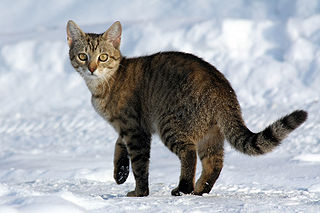

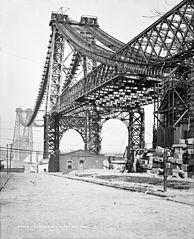

In [50]:
for image_features in parsed_image_dataset:
  image_raw = image_features['image_raw'].numpy()
  display.display(display.Image(data=image_raw))